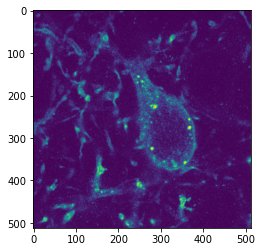

In [1]:
from PIL import Image
import numpy as np
from tifffile import imsave
import math
import matplotlib.pyplot as plt
import torch

FRAME_SIZE = 50
HALF_SIZE = int(FRAME_SIZE/2)
DECAY_RATE = 25
%matplotlib inline
Second_Layer_Kernel_Size = 151
    

def save_image_as_tiff(image,filename):
	image = np.einsum('ijk->kij', image)
	image = np.flip(image, axis=(1, 2))
	imsave(filename,image)

def Distance2Line(i, j, a, b, c):
    return abs(a * i + b * j + c) / math.sqrt(a**2 + b**2)

class LayerGeneration:
    def GenerateTopLayerWeights(angle, curvature):
        weight = np.zeros([FRAME_SIZE,FRAME_SIZE])
        a = math.cos(angle)
        b = math.sin(angle)
        c = -HALF_SIZE * (a + b)
        if curvature == 0:
            for i in range(FRAME_SIZE):
                for j in range(FRAME_SIZE):
                    dist = Distance2Line(i, j, a, b, c)
                    if (a * i + b * j + c < 0) and (dist < DECAY_RATE):
                        weight[i,j] = 1 - dist / DECAY_RATE
                    else:
                        weight[i,j] = 0 
        return weight
    
    
    def GenerateSecondLayerWeights(radius):
        L = np.arange(-(Second_Layer_Kernel_Size-1)/2, (Second_Layer_Kernel_Size-1)/2 + 1)
        L0 = np.arange(int(-Second_Layer_Kernel_Size/4), int(Second_Layer_Kernel_Size/4 + 1))
        Z, X, Y = np.meshgrid(L0, L, L)
        weight = X ** 2 + Y ** 2 + 4*(Z ** 2)
        weight = np.logical_and(weight <= radius ** 2, weight >= (radius-DECAY_RATE)**2)
        return np.einsum('kij->ijk', weight*255)
    
    
    def GenerateThirdLayerWeights(radius):
        L = np.arange(-radius, radius + 1)
        L0 = np.arange(int(-radius/2), int(radius/2 + 1))
        Z, X, Y = np.meshgrid(L0, L, L)
        weight = X ** 2 + Y ** 2 + 4*(Z ** 2)
        weight = np.logical_and(weight <= radius ** 2, weight >= (radius-DECAY_RATE)**2)
        return np.einsum('kij->ijk', weight*255)


def ReadDataFromTif(nframes, h, w):
    img_r = np.zeros((h, w, nframes))
    img_g = np.zeros((h, w, nframes))
    img_b = np.zeros((h, w, nframes))
    img_a = np.zeros((h, w, nframes))
    for i in range(nframes - 1):
        img.seek(i*4+1)
        img_r[:, :, i] = np.array(img)
        img.seek(i * 4 + 2)
        img_g[:, :, i] = np.array(img)
        img.seek(i * 4 + 3)
        img_b[:, :, i] = np.array(img)
        img.seek(i * 4 + 4)
        img_a[:, :, i] = np.array(img)
    img_rgba = np.max(np.stack([img_r, img_g, img_b, img_a]), axis=0)
    return img_rgba
        
def Read1FrameFromTif(nframes, h, w):
    img.seek(nframes * 4 + 1)
    img_r = np.array(img)
    img.seek(nframes * 4 + 2)
    img_g = np.array(img)
    img.seek(nframes * 4 + 3)
    img_b = np.array(img)
    img.seek(nframes * 4 + 4)
    img_a = np.array(img)
    img_rgba = np.max(np.stack([img_r, img_g, img_b, img_a]), axis=0)
    return img_rgba



def Layer1torchAbs(image,pattern):
    image_tensor=torch.from_numpy(image)
    pattern_tensor=torch.from_numpy(pattern)
    pattern_distance_map = torch.zeros((h-FRAME_SIZE+1,w-FRAME_SIZE+1))
    for i in range(h-FRAME_SIZE+1):
        for j in range(w-FRAME_SIZE+1):
            subimage=image_tensor[i:i+FRAME_SIZE,j:j+FRAME_SIZE]
            subimage=torch.div(subimage,torch.max(torch.abs(subimage)))
            pattern_distance_map[i,j] = torch.sum(torch.abs(torch.sub(subimage,pattern_tensor)))
    return pattern_distance_map.numpy()

def Layer1torchConv1frame(image,pattern):
    layer1 = torch.nn.Conv2d(1, 20, (FRAME_SIZE, FRAME_SIZE))
    pattern_tensor = torch.zeros(20,1, FRAME_SIZE, FRAME_SIZE)
    pattern_tensor[:,0,:,:] = torch.from_numpy(pattern)
    layer1.load_state_dict({'weight': pattern_tensor}, strict=False)
    image_tensor = torch.zeros((1,1,h,w))
    image_tensor[0,0,:,:] = torch.from_numpy(image)
    out_layer1=layer1(image_tensor)
    print(out_layer1.size())
    return out_layer1.detach().numpy()

def Layer1torchConv(image,pattern):
    image = np.einsum('ijk->kij', image)
    layer1 = torch.nn.Conv2d(1, 20, (FRAME_SIZE, FRAME_SIZE),padding='same')
    pattern_tensor = torch.zeros(20,1, FRAME_SIZE, FRAME_SIZE)
    pattern_tensor[:,0,:,:] = torch.from_numpy(pattern)
    layer1.load_state_dict({'weight': pattern_tensor}, strict=False)
    image_tensor = torch.zeros((nframes+Second_Layer_Kernel_Size-1,1,h+Second_Layer_Kernel_Size-1,w+Second_Layer_Kernel_Size-1))
    image_tensor[:,0,:,:] = torch.from_numpy(image)
    print(image_tensor.size())
    print(pattern_tensor.size())
    out_layer1=layer1(image_tensor)
    print('layer1 end')
    return out_layer1.detach().numpy()


def Layer1torchConvDeprecate(image,pattern):
    image = np.einsum('ijk->kij', image)
    layer1 = torch.nn.Conv2d(1, 20, (FRAME_SIZE, FRAME_SIZE),padding='same')
    pattern_tensor = torch.zeros(20,1, FRAME_SIZE, FRAME_SIZE)
    pattern_tensor[:,0,:,:] = torch.from_numpy(pattern)
    layer1.load_state_dict({'weight': pattern_tensor}, strict=False)
    image_tensor = torch.zeros((nframes,1,h,w))
    image_tensor[:,0,:,:] = torch.from_numpy(image)
    print(image_tensor.size())
    print(pattern_tensor.size())
    out_layer1=layer1(image_tensor)
    print('layer1 end')
    return out_layer1.detach().numpy()

def Layer2torchConv(image,pattern):
    torch.cuda.empty_cache()
    layer2 = torch.nn.Conv3d(1, 1, (pattern.shape[0], pattern.shape[1], pattern.shape[2]))
    pattern_tensor = torch.zeros(1,1, pattern.shape[0], pattern.shape[1], pattern.shape[2])
    pattern_tensor[0,0,:,:,:] = torch.from_numpy(pattern)
    layer2.load_state_dict({'weight': pattern_tensor}, strict=False)
    image_tensor = torch.zeros((1,1,image.shape[0],image.shape[1],image.shape[2]))
    print(image.shape)
    image_tensor[0,0,:,:,:] = torch.from_numpy(image)
    image_tensor=image_tensor.to('cuda')
    layer2=layer2.to('cuda')
    print('start layer2')
    out_layer2=layer2(image_tensor)
    out_layer2=out_layer2.to('cpu')
    print('end layer2')
    return out_layer2.detach().numpy()


def Layer3torchConv(image,pattern,size):
    layer3 = torch.nn.Conv3d(1, 1, (pattern.shape[0], pattern.shape[1], pattern.shape[2]))
    pattern_tensor = torch.zeros(1,1, pattern.shape[0], pattern.shape[1], pattern.shape[2])
    pattern_tensor[0,0,:,:,:] = torch.from_numpy(pattern)
    layer3.load_state_dict({'weight': pattern_tensor}, strict=False)
    image_tensor = torch.from_numpy(image)
    pd=tuple((int(pattern.shape[2]/2),int(pattern.shape[2]/2),int( pattern.shape[1]/2),int( pattern.shape[1]/2),int(pattern.shape[0]/2),int(pattern.shape[0]/2)))
    layer3=layer3.to('cuda')
    image_tensor=image_tensor.to('cuda')
    print('layer13 start')
    out_layer3=layer3(torch.nn.functional.pad(image_tensor,pd,'constant',0))
    out_layer3=out_layer3.to('cpu')
    print('layer3 end')
    return out_layer3.detach().numpy()


img = Image.open('C:/Users/brian/Documents/nTracer sample.tif')
h, w = np.shape(img)
nframes = int(img.n_frames/4)
image=Read1FrameFromTif(72,h,w)
image=image-np.min(image)-(np.max(image)-np.min(image))/2
fig=plt.figure()
plt.imshow(image)

In [2]:
#pytorch convolution algorithm
def Layer1TorchConv(image,pattern,normalization):
    torch.cuda.empty_cache()
    #image = np.einsum('ijk->kij', image)
    pattern_tensor = torch.zeros(20, 1, FRAME_SIZE, FRAME_SIZE)
    image_tensor = torch.zeros(1,1,h+Second_Layer_Kernel_Size-1,w+Second_Layer_Kernel_Size-1)
    image_tensor[0,0,:,:] = torch.from_numpy(image)
    pattern_tensor[:,0,:,:] = torch.from_numpy(pattern)
    layer1 = torch.nn.Conv2d(1, 20, (FRAME_SIZE, FRAME_SIZE))
    layer1.load_state_dict({'weight': pattern_tensor}, strict=False)
    image_tensor=torch.nn.functional.pad(image_tensor, tuple((HALF_SIZE, HALF_SIZE, HALF_SIZE, HALF_SIZE)),'reflect')
    pooling=torch.nn.MaxPool2d(FRAME_SIZE,stride=1)
    out_layer1=layer1(image_tensor)
    out_layer1=torch.max(out_layer1,1).values
    if(normalization==True):
        normalization_map=pooling(image_tensor)
        normalization_map=normalization_map[0,:,:,:]
        out_layer1 = torch.div(out_layer1,normalization_map)
    return out_layer1.detach().numpy()


image=ReadDataFromTif(nframes,h,w)
image=image-np.min(image)
image=image/np.max(image)

pattern_distance_map=np.zeros((20,FRAME_SIZE,FRAME_SIZE))
for angle in range(20):
    pattern_distance_map[angle,:,:]=LayerGeneration.GenerateTopLayerWeights(angle*0.314,0)
pd=((int((Second_Layer_Kernel_Size-1)/2),int((Second_Layer_Kernel_Size-1)/2)),(int((Second_Layer_Kernel_Size-1)/2),int((Second_Layer_Kernel_Size-1)/2)),(int(Second_Layer_Kernel_Size/4),int(Second_Layer_Kernel_Size/4)))
image=np.pad(image,pd,mode='reflect')
Layer1out = np.zeros((image.shape[2],1,image.shape[0]+1,image.shape[1]+1))
for frame in range(image.shape[2]):
    Layer1out_map = Layer1TorchConv(image[:,:,frame],pattern_distance_map,False)
    Layer1out[frame,:,:,:]=Layer1out_map
print('finished')

finished


In [3]:
Layer1outmask=Layer1out[:,0,:,:]
print(np.min(Layer1outmask),np.max(Layer1outmask))
Layer1outmask=Layer1outmask-np.min(Layer1outmask)-(np.max(Layer1outmask)-np.min(Layer1outmask))*1/10
Layer1outmask=255*Layer1outmask/np.max(Layer1outmask)
Layer1outmask=Layer1outmask.astype(int)
Layer1outmask[Layer1outmask<0]=0

Layer1outmask = np.flip(Layer1outmask, axis=(1, 2))
imsave('C:/Users/brian/Documents/Layer1ConvOut.tif',Layer1outmask)

0.019310373812913895 467.22100830078125


(210, 663, 663)
0 255


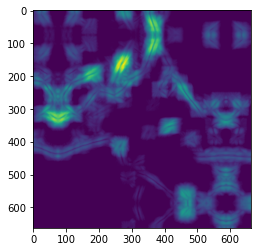

In [4]:
print(Layer1outmask.shape)
print(np.min(Layer1outmask),np.max(Layer1outmask))
plt.imshow(Layer1outmask[40,:,:])

In [5]:
pattern2=LayerGeneration.GenerateSecondLayerWeights(70)
print(pattern2.shape,Layer1out[:,0,:,:].shape)


(75, 151, 151) (210, 663, 663)


In [6]:
Layer2out_map = Layer2torchConv(Layer1outmask.copy(),pattern2)

(210, 663, 663)
start layer2
end layer2


In [7]:
Layer2out_mask=Layer2out_map[0,0,:,:,:]
Layer2out_mask=Layer2out_mask-np.min(Layer2out_mask)-(np.max(Layer2out_mask)-np.min(Layer2out_mask))*1/2
Layer2out_mask=250*Layer2out_mask/np.max(Layer2out_mask)
Layer2out_mask=-Layer2out_mask.astype(int)
Layer2out_mask[Layer2out_mask<0]=0
imsave('C:/Users/brian/Documents/Layer2ConvOut.tif',Layer2out_mask)

In [8]:
pattern3=LayerGeneration.GenerateThirdLayerWeights(70)
Layer3out_map = Layer3torchConv(Layer2out_map-np.min(Layer2out_map),pattern3,141)

layer13 start
layer3 end


In [9]:
Layer3out_mask = Layer3out_map[0,0,:,:,:]
Layer3out_mask=Layer3out_mask-np.min(Layer3out_mask)-(np.max(Layer3out_mask)-np.min(Layer3out_mask))*1/2
Layer3out_mask=250*Layer3out_mask/np.max(Layer3out_mask)
Layer3out_mask=-Layer3out_mask.astype(int)
Layer3out_mask[Layer3out_mask<0]=0
imsave('C:/Users/brian/Documents/Layer3ConvOut.tif',Layer3out_mask)